In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("/home/mizworski/Repos/xgboost/python-package/")
sys.path.append("/home/mizworski/Repos/LightGBM/python-package/")
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.utils.validation import column_or_1d
from scipy import interp
from scipy import stats

In [2]:
date_parse_format = '%Y-%m-%d'

def preprocess_data(data):
    now = datetime.strptime(data.contact_date.max(), date_parse_format)
#     data['sum_nan'] = (data[['default', 'loan', 'education', 'housing', 'job']] == 'unknown').sum(axis=1)
    data['age'] = data.apply(lambda r: int((now - datetime.strptime(r.birth_date, date_parse_format)).days / 365.25), axis=1)
    data.drop('birth_date', axis=1, inplace=True)
#     data['contact_weekday'] = data.apply(lambda r: (datetime.strptime(r.contact_date, date_parse_format)).weekday(), axis=1)
    
#     data['age_range'] = data['age'].apply(age2class)
#     data.drop('age', axis=1, inplace=True)11
#     categorical_cols = list(set(data.columns) - set(['birth_date', 'contact_date', 'pdays', 'campaign', 'y']))

    categorical_cols = list(set(data.columns) - set(['birth_date', 'contact_date', 'previous', 'pdays', 'campaign', 'y','age', 'sum_nan']))
    X = pd.get_dummies(data, columns=categorical_cols)
    X['contacted'] = pd.get_dummies(X.pdays < 999, drop_first=True)
    
    X['days_since_contact'] =  X.apply(lambda r: ((now - datetime.strptime(r.contact_date, date_parse_format)).days), 
                                       axis=1)
    
    X.drop('contact_date', axis=1, inplace=True)
    
    train_x = X[X.y != 'unknown']
    test_x = X[X.y == 'unknown']
    train_y = train_x['y']
    train_y = pd.get_dummies(train_y, drop_first=True)
    train_x = train_x.drop('y', axis=1)
    test_x = test_x.drop('y', axis=1)
    
#     train_y = column_or_1d(train_y)
#     train_x = train_x.as_matrix()
#     test_x = test_x.as_matrix()
    
    return train_x, train_y, test_x
    

In [3]:
date_parse_format = '%Y-%m-%d'
def age2class(age):
    if age < 20:
        return 0
    if age < 27:
        return 1
    
    if age < 32:
        return 2
    if age < 36:
        return 3
    
    if age < 42:
        return 4
    
    if age < 55:
        return 5
    if age < 75:
        return 6
    return 7

def preprocess_data(data):
    now = datetime.strptime(data.contact_date.max(), date_parse_format)
    data['sum_nan'] = (data[['default', 'loan', 'education', 'housing', 'job']] == 'unknown').sum(axis=1)
    data['age'] = data.apply(lambda r: int((now - datetime.strptime(r.birth_date, date_parse_format)).days / 365.25), axis=1)
    data.drop('birth_date', axis=1, inplace=True)
#     data['contact_weekday'] = data.apply(lambda r: (datetime.strptime(r.contact_date, date_parse_format)).weekday(), axis=1)
    
#     data['age_range'] = data['age'].apply(age2class)
#     data.drop('age', axis=1, inplace=True)11
    
    categorical_cols = list(set(data.columns) - set(['birth_date', 'contact_date', 'pdays', 'campaign', 'y','age', 'sum_nan']))
    X = pd.get_dummies(data, columns=categorical_cols)
    X['contacted'] = pd.get_dummies(X.pdays < 999, drop_first=True)
    
    X['days_since_contact'] =  X.apply(lambda r: int((now - datetime.strptime(r.contact_date, date_parse_format)).days), 
                                       axis=1)
    
    X.drop('contact_date', axis=1, inplace=True)
    
    train_x = X[X.y != 'unknown']
    test_x = X[X.y == 'unknown']
    train_y = train_x['y']
    train_y = pd.get_dummies(train_y, drop_first=True)
    train_x = train_x.drop('y', axis=1)
    test_x = test_x.drop('y', axis=1)
    
#     train_y = column_or_1d(train_y)
#     train_x = train_x.as_matrix()
#     test_x = test_x.as_matrix()
    
    return train_x, train_y, test_x
    

In [4]:
df = pd.read_csv('../data/bank-classification.csv', index_col=0)
df = df.sample(frac=1)
X_train, Y_train, X_test = preprocess_data(df)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from numpy import random
from sklearn.preprocessing import PolynomialFeatures

In [5]:
X_train['houseXmarried'] = X_train.housing_yes * X_train.marital_married
X_train['uniXmarried'] = X_train['education_university.degree'] * X_train.marital_married
X_train['highschoolXmarried'] = X_train['education_high.school'] * X_train.marital_married
X_train['job_high_paid'] = X_train.job_entrepreneur + X_train.job_management + X_train.job_technician
X_train['campaignXdays_since_contact']= X_train.campaign * X_train.days_since_contact
X_train['campaignXpoutcome_success']= X_train.campaign * X_train.poutcome_success

X_test['houseXmarried'] = X_test.housing_yes * X_test.marital_married
X_test['uniXmarried'] = X_test['education_university.degree'] * X_test.marital_married
X_test['highschoolXmarried'] = X_test['education_high.school'] * X_test.marital_married
X_test['job_high_paid'] = X_test.job_entrepreneur + X_test.job_management + X_test.job_technician
X_test['campaignXdays_since_contact']= X_test.campaign * X_test.days_since_contact
X_test['campaignXpoutcome_success']= X_test.campaign * X_test.poutcome_success

In [6]:
X_train.head()

,campaign,pdays,sum_nan,age,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,...,marital_single,marital_unknown,contacted,days_since_contact,houseXmarried,uniXmarried,highschoolXmarried,job_high_paid,campaignXdays_since_contact,campaignXpoutcome_success
id,,,,,,,,,,,,,,,,,,,,,
39148,1,5,0,19,0,1,0,0,0,0,...,1,0,1,266,0,0,0,0,266,1
7007,1,999,1,44,0,0,0,0,0,0,...,0,0,0,943,0,1,0,1,943,0
34635,2,999,1,40,0,0,1,0,0,0,...,0,0,0,565,1,0,0,1,1130,0
6068,3,999,1,41,0,0,0,0,0,0,...,0,0,0,938,0,1,0,0,2814,0
15682,6,999,0,33,0,0,0,1,0,0,...,1,0,0,855,0,0,0,0,5130,0


In [7]:
model = XGBClassifier(max_depth=4, gamma=3, reg_alpha=0.2137, min_child_weight=2, n_estimators=800,
                      reg_lambda=1, subsample=1, max_delta_step=5, learning_rate=0.006)
cv = StratifiedKFold(n_splits=10)


X = X_train.as_matrix()
Y = column_or_1d(Y_train)

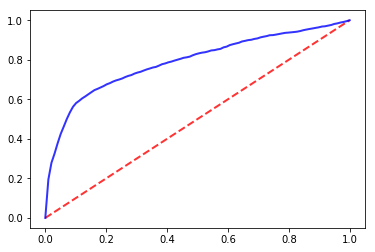

In [8]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i=0

for train, test in cv.split(X, Y):
    probas_ = model.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
#     plt.show()

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.show()

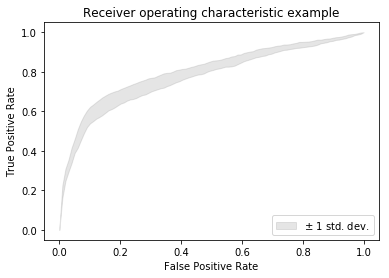

In [9]:
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [10]:
mean_auc

0.78918378312162341

In [11]:
from xgboost import plot_importance

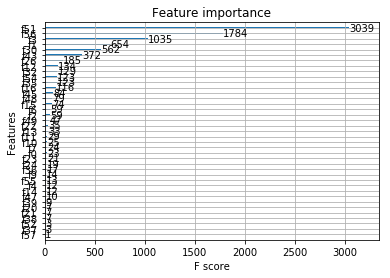

In [12]:
plot_importance(model)
plt.show()

In [13]:
fscore = model.get_booster().get_fscore().items()
fscore = sorted(fscore,key=lambda x:(-x[1],x[0]))
for key, score in fscore:
    fname = X_train.columns[int(key[1:])]
    print('feature: {} score={}'.format(fname, score))

feature: days_since_contact score=3039
feature: campaignXdays_since_contact score=1784
feature: age score=1035
feature: pdays score=654
feature: contact_cellular score=562
feature: poutcome_failure score=372
feature: job_unknown score=185
feature: housing_no score=134
feature: default_no score=129
feature: previous_0 score=123
feature: highschoolXmarried score=123
feature: job_blue-collar score=116
feature: poutcome_success score=84
feature: marital_single score=79
feature: job_admin. score=74
feature: sum_nan score=59
feature: education_basic.9y score=59
feature: marital_unknown score=47
feature: job_services score=35
feature: housing_unknown score=33
feature: education_unknown score=29
feature: education_university.degree score=25
feature: education_high.school score=24
feature: campaign score=23
feature: job_student score=21
feature: job_technician score=19
feature: previous_1 score=17
feature: education_professional.course score=14
feature: job_high_paid score=13
feature: housing_y

In [14]:
X_train.columns

Index(['campaign', 'pdays', 'sum_nan', 'age', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'housing_no',
       'housing_unknown', 'housing_yes', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'default_no',
       'default_unknown', 'default_yes', 'previous_0', 'previous_1',
       'previous_2', 'previous_3', 'previous_4', 'previous_5', 'previous_6',
       'previous_7', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'marital_divorced', 'marital_married',
       'marital_single', 'marital_unknown', 'contacted', 'days_since_cont

In [15]:
X_train.head()

,campaign,pdays,sum_nan,age,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,...,marital_single,marital_unknown,contacted,days_since_contact,houseXmarried,uniXmarried,highschoolXmarried,job_high_paid,campaignXdays_since_contact,campaignXpoutcome_success
id,,,,,,,,,,,,,,,,,,,,,
39148,1,5,0,19,0,1,0,0,0,0,...,1,0,1,266,0,0,0,0,266,1
7007,1,999,1,44,0,0,0,0,0,0,...,0,0,0,943,0,1,0,1,943,0
34635,2,999,1,40,0,0,1,0,0,0,...,0,0,0,565,1,0,0,1,1130,0
6068,3,999,1,41,0,0,0,0,0,0,...,0,0,0,938,0,1,0,0,2814,0
15682,6,999,0,33,0,0,0,1,0,0,...,1,0,0,855,0,0,0,0,5130,0


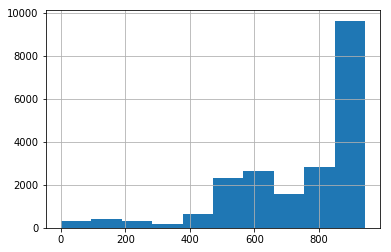

In [16]:
X_train['days_since_contact'].hist()
plt.show()

In [17]:
X_train.columns

Index(['campaign', 'pdays', 'sum_nan', 'age', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'housing_no',
       'housing_unknown', 'housing_yes', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'default_no',
       'default_unknown', 'default_yes', 'previous_0', 'previous_1',
       'previous_2', 'previous_3', 'previous_4', 'previous_5', 'previous_6',
       'previous_7', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'marital_divorced', 'marital_married',
       'marital_single', 'marital_unknown', 'contacted', 'days_since_cont

In [18]:
model.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=3, learning_rate=0.006, max_delta_step=5,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=800,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.2137, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [19]:
y_pred = model.predict(X_test.as_matrix())
y_proba = model.predict_proba(X_test.as_matrix())

In [20]:
test_indices = X_test.index.values
test_indices
results = pd.DataFrame({'id':test_indices, 'y':y_proba[:, 1]})
results_sorted = results.sort_values(['id'])
results_sorted.to_csv('submission_no_interactions.csv', index=False)

In [21]:
y_pred

array([0, 1, 0, ..., 0, 0, 0], dtype=uint8)

In [22]:
results.head()

,id,y
0,23704,0.068823
1,40405,0.576561
2,25872,0.079354
3,13137,0.057701
4,39182,0.539764
